In [ ]:
import pandas as pd
import numpy as np

!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
import nltk
# Split review into sentences
nltk.download('punkt')

nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet') 

import re

nltk.download('averaged_perceptron_tagger')

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import downloader

from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.pyplot as plt

import pickle

In [ ]:
#Load data
df = pd.read_json(path+'full.json')
df = df[(df.review_language == 'en')][6:]

In [ ]:
# Split review into sentences
df['split_review'] = df.review.map(lambda x : nltk.tokenize.sent_tokenize(x))

review_ids = []
sentences = []
for i in range(df.shape[0]):
  for s in df['split_review'].values[i]:
    review_ids.append(df.review_id.values[i])
    sentences.append(s)

data_tuples = list(zip(review_ids,sentences))
df_s = pd.DataFrame(data_tuples, columns=['review_id','review_sentence'])

In [ ]:
# Preprocessing
df_s['sentence_cleaned'] = df_s.review_sentence.map(lambda x: nltk.tokenize.word_tokenize(x))
sentence_cleaned = [[word.lower() for word in sentence] for sentence in df_s['sentence_cleaned'].values]
stop_words = stopwords.words('english')
sentence_cleaned = [[word for word in sentence if word not in stop_words] for sentence in sentence_cleaned]
lemmatizer = WordNetLemmatizer()   
sentence_cleaned = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in df_s['sentence_cleaned'].values]
df_s['sentence_cleaned'] = sentence_cleaned
df_s['sentence_cleaned'] = df_s['sentence_cleaned'].map(lambda x: " ".join(x))
df_s['sentence_cleaned'] = df_s['sentence_cleaned'].map(lambda x: re.sub('[,\.!?/\';\&]', '', x))
# sentence_cleaned = [[word for (word,pos) in nltk.pos_tag(nltk.tokenize.word_tokenize(sentence)) if pos in ['NN','JJ','VB']] for sentence in df_s['sentence_cleaned'].values]
df_s['sentence_cleaned'] = sentence_cleaned
df_s['sentence_cleaned'] = df_s['sentence_cleaned'].map(lambda x: " ".join(x))
df_s.to_csv(path+'full.csv')

100%|██████████| 6/6 [02:14<00:00, 22.47s/it]


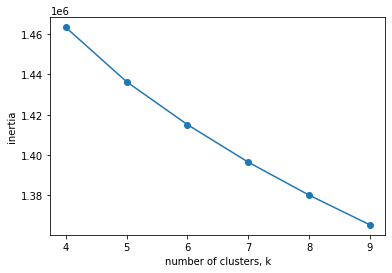

In [ ]:
# Unsupervised topic classification
df_s['sentence_cleaned'] = df_s.sentence_cleaned.map(lambda x: nltk.tokenize.word_tokenize(x))
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(df_s['sentence_cleaned'].values)]
model = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 1, epochs = 100)
embeddings = model.docvecs.vectors_docs
with open(path+'embeddings.pkl','wb') as f:
    pickle.dump(embeddings, f)

# with open(path+'embeddings.pkl','rb') as f:
#     embeddings = pickle.load(f)

ks = range(4, 10)
inertias = []

for k in tqdm(ks):
    # Create a KMeans instance with k clusters: model
    km = KMeans(n_clusters = k)
    
    # Fit model to samples
    km.fit(embeddings)
    
    # Append the inertia to the list of inertias
    inertias.append(km.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()